<a href="https://colab.research.google.com/github/Akshay523272/Lung-and-Colon-Cancer-DeepLearning-proj/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
100% 1.76G/1.76G [00:55<00:00, 35.4MB/s]
100% 1.76G/1.76G [00:55<00:00, 34.1MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('lung-and-colon-cancer-histopathological-images.zip', 'r') as zip_ref:
    zip_ref.extractall('lung-and-colon-cancer-histopathological-images')


In [ ]:
!ls lung-and-colon-cancer-histopathological-images


lung_colon_image_set


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
# Generate data paths with labels
data_dir = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

filepaths               labels
0      /content/lung-and-colon-cancer-histopathologic...  Lung Adenocarcinoma
1      /content/lung-and-colon-cancer-histopathologic...  Lung Adenocarcinoma
2      /content/lung-and-colon-cancer-histopathologic...  Lung Adenocarcinoma
3      /content/lung-and-colon-cancer-histopathologic...  Lung Adenocarcinoma
4      /content/lung-and-colon-cancer-histopathologic...  Lung Adenocarcinoma
...                                                  ...                  ...
24995  /content/lung-and-colon-cancer-histopathologic...  Colon Benign Tissue
24996  /content/lung-and-colon-cancer-histopathologic...  Colon Benign Tissue
24997  /content/lung-and-colon-cancer-histopathologic...  Colon Benign Tissue
24998  /content/lung-and-colon-cancer-histopathologic...  Colon Benign Tissue
24999  /content/lung-and-colon-cancer-histopathologic...  Colon Benign Tissue

[25000 rows x 2 columns]

In [ ]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


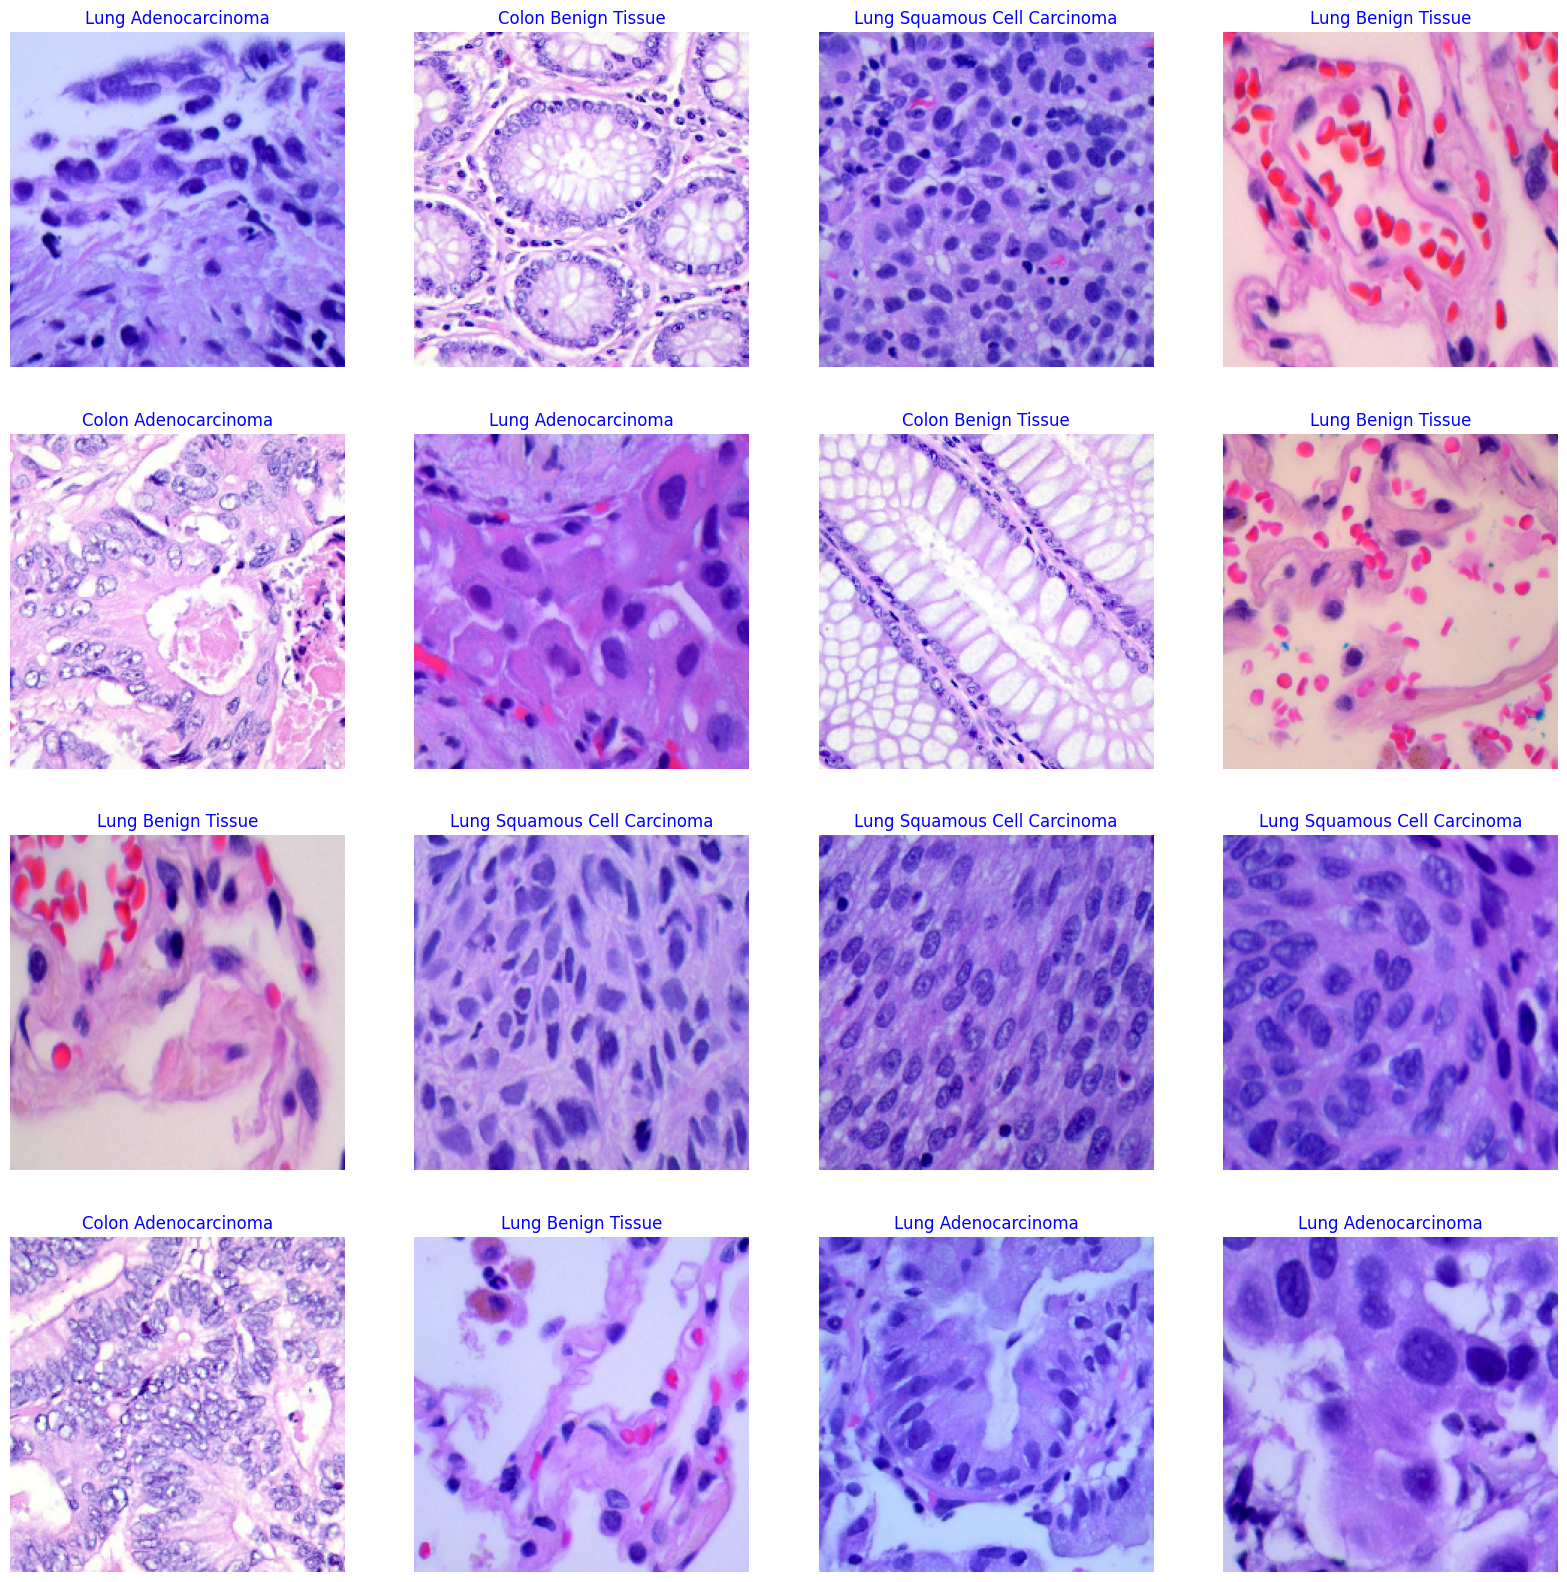

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Dense, Multiply, Reshape, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# ✅ Define Global Context Attention Layer
class GlobalContextAttention(Layer):
    def __init__(self, channels, **kwargs):  # FIXED '__init__' mistake
        super(GlobalContextAttention, self).__init__(**kwargs)
        self.channels = channels
        self.dense1 = Dense(channels // 16, activation='relu')  # Reduction
        self.dense2 = Dense(channels, activation='sigmoid')  # Scaling

    def call(self, inputs):
        x = GlobalAveragePooling2D()(inputs)
        x = Reshape((1, 1, self.channels))(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return Multiply()([inputs, x])

    def get_config(self):
        config = super().get_config()
        config.update({"channels": self.channels})
        return config

# ✅ Build CNN Model with Global Context Attention
model = Sequential([
    # Early Layers (No GC Attention)
    Conv2D(64, (3,3), padding="same", activation="relu", input_shape=img_shape),
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3,3), padding="same", activation="relu"),
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    # Add GC Attention only in deeper layers
    Conv2D(256, (3,3), padding="same", activation="relu"),
    Conv2D(256, (3,3), padding="same", activation="relu"),
    GlobalContextAttention(256),  # GC applied here
    MaxPooling2D((2, 2)),

    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    GlobalContextAttention(512),  # GC applied here
    MaxPooling2D((2, 2)),

    Conv2D(512, (3,3), padding="same", activation="relu"),
    Conv2D(512, (3,3), padding="same", activation="relu"),
    GlobalContextAttention(512),  # GC applied here
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.4),  # Add dropout for regularization
    Dense(64, activation="relu"),
    Dense(5, activation="softmax")  # Updated to match the number of classes
])

# ✅ Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Show model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_context_attention             │ (None, 56, 56, 256)         │           8,464 │
│ (GlobalContextAttention)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_context_attention_1           │ (None, 28, 28, 512)         │          33,312 │
│ (GlobalContextAttention)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_context_attention_2           │ (None, 14, 14, 512)         │          33,312 │
│ (GlobalContextAttention)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,7

 Total params: 15,919,637 (60.73 MB)

 Trainable params: 15,919,637 (60.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

epochs = 20   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 362s 941ms/step - accuracy: 0.4007 - loss: 1.2143 - val_accuracy: 0.8596 - val_loss: 0.3352
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 231s 736ms/step - accuracy: 0.8581 - loss: 0.3753 - val_accuracy: 0.9180 - val_loss: 0.2142
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 230s 736ms/step - accuracy: 0.9079 - loss: 0.2398 - val_accuracy: 0.9572 - val_loss: 0.1137
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 230s 734ms/step - accuracy: 0.9409 - loss: 0.1649 - val_accuracy: 0.9576 - val_loss: 0.1113
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 231s 736ms/step - accuracy: 0.9514 - loss: 0.1412 - val_accuracy: 0.9760 - val_loss: 0.0656
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 262s 736ms/step - accuracy: 0.9650 - loss: 0.0930 - val_accuracy: 0.9332 - val_loss: 0.1636
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 230s 735ms/step - accuracy: 0.9678 - loss: 0.0876 - val_accuracy: 0.9804 - val_loss: 0.0655
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 230s 734ms/step - accuracy: 0.9749 -

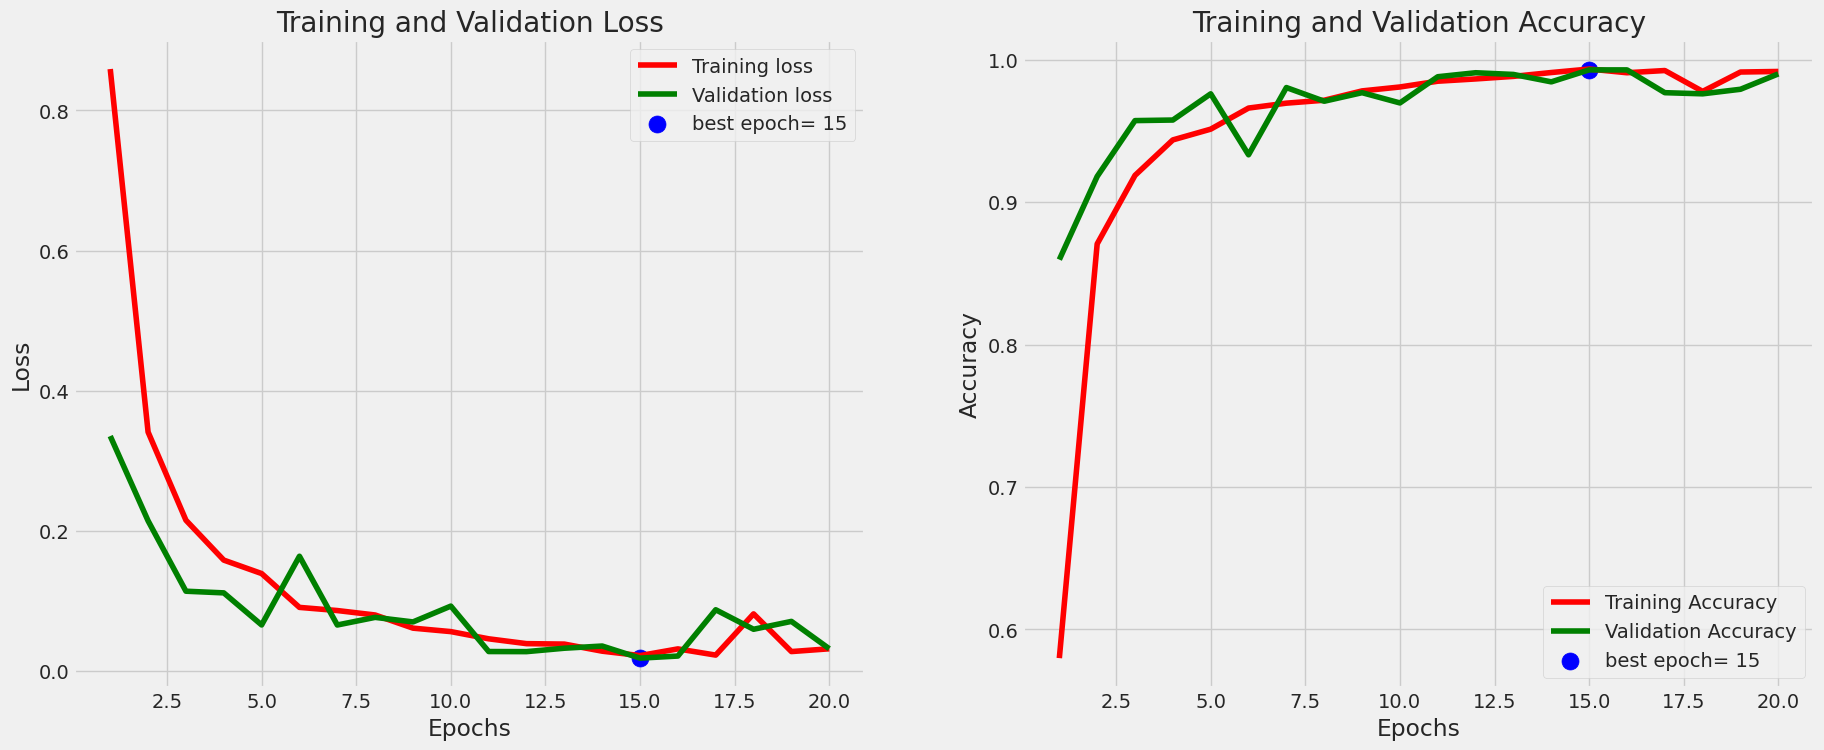

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.9958 - loss: 0.0149
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - accuracy: 0.9870 - loss: 0.0580
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9876 - loss: 0.0371
Train Loss:  0.010479768738150597
Train Accuracy:  0.9965624809265137
--------------------
Valid Loss:  0.043072182685136795
Valid Accuracy:  0.9900000095367432
--------------------
Test Loss:  0.031637050211429596
Test Accuracy:  0.9900000095367432


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 355ms/step


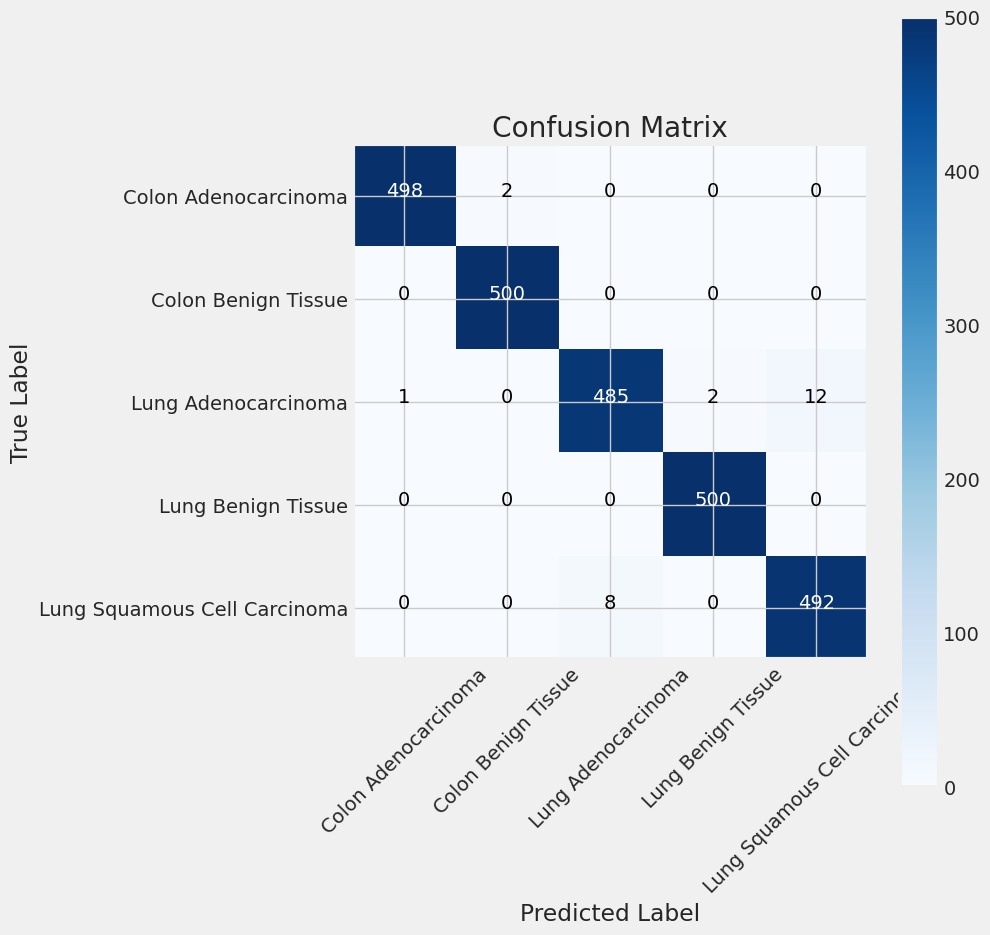

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       500
         Colon Benign Tissue       1.00      1.00      1.00       500
         Lung Adenocarcinoma       0.98      0.97      0.98       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       0.98      0.98      0.98       500

                    accuracy                           0.99      2500
                   macro avg       0.99      0.99      0.99      2500
                weighted avg       0.99      0.99      0.99      2500



In [ ]:
model.save('Model.h5')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
try:
    loaded_model = tf.keras.models.load_model(
        'Model.h5',
        custom_objects={'GlobalContextAttention': GlobalContextAttention}
    )
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")

Model loaded successfully.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Get true labels from test generator
true_labels = test_gen.classes  # Actual labels of test images

# Predict the classes
y_pred_probs = model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Compute image-level accuracy
image_level_accuracy = accuracy_score(true_labels, y_pred)

print(f"Image Level Accuracy: {image_level_accuracy:.4f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step
Image Level Accuracy: 0.9900
